In [7]:
import tensorflow as tf
import numpy as np
from scipy.misc import imread, imresize
from pprint import pprint

# class names for ImaneNet dataset
from imagenet_classes import class_names

import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline

In [2]:
# dir for tensorboard file (for graph visualization)
logs_path = 'logs/0.1/'

if tf.gfile.Exists(logs_path):
    tf.gfile.DeleteRecursively(logs_path)
tf.gfile.MakeDirs(logs_path)

In [3]:
# information about image size
IMG_W = 224
IMG_H = 224
CHANNELS = 3

## Load weights (numpy arrays)

In [5]:
VGG19_weights_file = "data/VGG/vgg19.npy"
VGG19_weights = np.load(VGG19_weights_file, encoding='latin1').item()
print(type(VGG19_weights))

<class 'dict'>


In [10]:
pprint(list(VGG19_weights.keys()))

['conv3_4',
 'conv1_2',
 'conv3_3',
 'conv4_2',
 'conv4_1',
 'conv3_1',
 'conv5_1',
 'conv3_2',
 'fc7',
 'conv4_3',
 'conv2_1',
 'conv5_3',
 'conv2_2',
 'conv4_4',
 'conv1_1',
 'conv5_2',
 'fc6',
 'fc8',
 'conv5_4']


In [11]:
# `conv5_1` : kernel conv with size 3x3, to transform 512 feature maps into 512 feature maps
print(VGG19_weights['conv5_1'][0].shape)
print(VGG19_weights['conv5_1'][1].shape)

(3, 3, 512, 512)
(512,)


In [12]:
def _get_weights(layer_name, weights):
    """
    Load weights with name 'layer_name'
    weights[layer_name][0] : weights (conv kernel or matrix)
    weights[layer_name][1] : bias vector
    """
    W = weights[layer_name][0]
    b = weights[layer_name][1]
    return W, b

In [13]:
W, b = _get_weights('fc6', VGG19_weights)
print(W.shape)
print(b.shape)

(25088, 4096)
(4096,)


## VGG Construction 

- store tensors in a python dictionary 
    - after each "conv + ReLU"
    - after each "pooling" (max pooling)
    - after each "dense layer + ReLU"
    - after softmax layer

In [14]:
model = {}

In [15]:
sess = tf.InteractiveSession()

In [16]:
# input : batch of 1 image. 
# we are using tf.Variable() to perform optimization on this image (see next notebooks)
model['input'] = tf.get_variable("input", dtype = 'float32', shape=(1,IMG_W, IMG_H, CHANNELS))

### Preprocessing : RGB-> BRG and mean substraction 

In [17]:
def _preprocess(prev_layer):
    """
    Apply preprocessing step : subtract image mean from ImageNet dataset.
    And RGB -> BGR 
    """
    # BGR format 
    with tf.name_scope("preprocess"):
        VGG_MEAN = [103.939, 116.779, 123.68]
    
        red, green, blue = tf.split(axis=3, num_or_size_splits=3, value=prev_layer)
        bgr = tf.concat(axis=3, values=[blue - VGG_MEAN[0], green - VGG_MEAN[1], red - VGG_MEAN[2],])
    return bgr

In [18]:
model["preprocess"] = _preprocess(model['input'])

### Variable sharing 

In more complex models for style transfer we will use many VGG networks (as encoder, or for style and content losses). 

So we can use `tf.get_variable()` and `tf.variable_scope()` for variable sharing. 

See TensorFlow tutorial about variable sharing for more information : 
    - https://www.tensorflow.org/programmers_guide/variable_scope

**Notes** : 
- variables will be set with `trainable=False`
- initializers are `tf.constant_initialier(values)` where values are the parameters, learned during training on ImageNet. 

In [19]:
def _conv2d_relu(prev_layer, layer_name, weights):
    """
    Return the Conv2D + RELU layer using the weights, biases from the VGG
    model at 'layer_name'.
    """
    W_np, b_np = _get_weights(layer_name, weights)
    
    with tf.variable_scope(layer_name):
        
        W = tf.get_variable('W', shape=tuple(W_np.shape),
                            dtype=W_np.dtype, trainable=False,
                            initializer=tf.constant_initializer(W_np))
        
        b = tf.get_variable('b', shape=tuple(b_np.shape),
                            dtype=b_np.dtype, trainable=False,
                            initializer=tf.constant_initializer(b_np))
        
        conv = tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME')
        out = tf.nn.bias_add(conv, b)
        acti =  tf.nn.relu(out, name=layer_name)
        return acti

In [20]:
def _pool(prev_layer, layer_name):
    """
    Return the MaxPooling layer.
    """
    with tf.name_scope(layer_name):
        return tf.nn.max_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [21]:
model['conv1_1']  = _conv2d_relu(model['preprocess'], 'conv1_1', VGG19_weights)
model['conv1_2']  = _conv2d_relu(model['conv1_1'], 'conv1_2', VGG19_weights)
model['pool_1'] = _pool(model['conv1_2'], 'pool_1')

model['conv2_1']  = _conv2d_relu(model['pool_1'], 'conv2_1', VGG19_weights)
model['conv2_2']  = _conv2d_relu(model['conv2_1'], 'conv2_2', VGG19_weights)
model['pool_2'] = _pool(model['conv2_2'], 'pool_2')

model['conv3_1']  = _conv2d_relu(model['pool_2'], 'conv3_1', VGG19_weights)
model['conv3_2']  = _conv2d_relu(model['conv3_1'], 'conv3_2', VGG19_weights)
model['conv3_3']  = _conv2d_relu(model['conv3_2'], 'conv3_3', VGG19_weights)
model['conv3_4']  = _conv2d_relu(model['conv3_3'], 'conv3_4', VGG19_weights)
model['pool_3'] = _pool(model['conv3_4'], 'pool_3')

model['conv4_1']  = _conv2d_relu(model['pool_3'], 'conv4_1', VGG19_weights)
model['conv4_2']  = _conv2d_relu(model['conv4_1'], 'conv4_2', VGG19_weights)
model['conv4_3']  = _conv2d_relu(model['conv4_2'], 'conv4_3', VGG19_weights)
model['conv4_4']  = _conv2d_relu(model['conv4_3'], 'conv4_4', VGG19_weights)
model['pool_4'] = _pool(model['conv4_4'], 'pool_4')

model['conv5_1']  = _conv2d_relu(model['pool_4'], 'conv5_1', VGG19_weights)
model['conv5_2']  = _conv2d_relu(model['conv5_1'], 'conv5_2', VGG19_weights)
model['conv5_3']  = _conv2d_relu(model['conv5_2'], 'conv5_3', VGG19_weights)
model['conv5_4']  = _conv2d_relu(model['conv5_3'], 'conv5_4', VGG19_weights)
model['pool_5'] = _pool(model['conv5_4'], 'pool_5')

In [22]:
def _flatten(prev_layer):
    """
    Reshape layer, flatten operation.
    """
    
    with tf.name_scope('flatten'):
        shape = int(np.prod(prev_layer.get_shape()[1:]))
        return tf.reshape(prev_layer, [-1, shape])

In [23]:
model['flatten'] = _flatten(model['pool_5'])

In [24]:
def _fc_relu(prev_layer, layer_name, weights):
    """
    Return the Dense/Fully Connected  + ReLU layer using the weights, biases from the VGG model
    """
    W_np, b_np = _get_weights(layer_name, weights)
    with tf.variable_scope(layer_name):
        W = tf.get_variable('W', shape=tuple(W_np.shape),
                            dtype=W_np.dtype, trainable=False,
                            initializer=tf.constant_initializer(W_np))
        
        b = tf.get_variable('b', shape=tuple(b_np.shape),
                            dtype=b_np.dtype, trainable=False,
                            initializer=tf.constant_initializer(b_np))
        
        return tf.nn.relu(tf.nn.bias_add(tf.matmul(prev_layer, W), b))

def _fc_linear(prev_layer, layer_name, weights):
        
    W_np, b_np = _get_weights(layer_name, weights)
    with tf.variable_scope(layer_name):
        W = tf.get_variable('W', shape=tuple(W_np.shape),
                            dtype=W_np.dtype, trainable=False,
                            initializer=tf.constant_initializer(W_np))
        
        b = tf.get_variable('b', shape=tuple(b_np.shape),
                            dtype=b_np.dtype, trainable=False,
                            initializer=tf.constant_initializer(b_np))
        
        return tf.nn.bias_add(tf.matmul(prev_layer, W), b)

In [25]:
model['fc6'] = _fc_relu(model['flatten'], 'fc6', VGG19_weights)
model['fc7'] = _fc_relu(model['fc6'], 'fc7', VGG19_weights)
model['fc8'] = _fc_linear(model['fc7'], 'fc8', VGG19_weights)

In [26]:
def _prob(prev_layer, layer_name):
    """
    Returns the softmax.
    """
    with tf.name_scope(layer_name):
        return tf.nn.softmax(prev_layer)

In [27]:
model['prob'] = _prob(model['fc8'], 'prob')

In [28]:
# variable initialization : assign trained values (conv kernels, matrices ans biases vectors) to the graph
sess.run(tf.global_variables_initializer())

In [29]:
# add the graph to TensorBoard visualization
writer = tf.summary.FileWriter(logs_path, sess.graph)

## Image classification

uint8


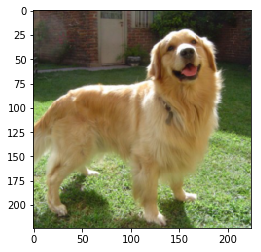

In [31]:
img1 = imread('images/golden_retriever.jpg')
img1 = imresize(img1, (IMG_W, IMG_H))
img1 = img1.reshape((1, IMG_W, IMG_H, CHANNELS))
print(img1.dtype)
plt.imshow(img1[0])

In [32]:
# assign to the input the image 
_ = sess.run(model['input'].assign(img1))

In [33]:
prob = sess.run(model['prob'])[0]
preds = (np.argsort(prob)[::-1])[0:5]
for p in preds:
    print(class_names[p], prob[p])

golden retriever 0.294837
Great Pyrenees 0.075777
Tibetan mastiff 0.0686696
Saint Bernard, St Bernard 0.0465517
Newfoundland, Newfoundland dog 0.0462222


## Get variables

We can get variables already defined in the graph. 
We w

In [35]:
with tf.variable_scope("conv5_1", reuse=True):
    W = tf.get_variable("W")
    b = tf.get_variable("b")

In [41]:
print(str(W.name) + " --> " + str(W.get_shape()))
print(str(b.name) + " --> " + str(b.get_shape()))

conv5_1/W:0 --> (3, 3, 512, 512)
conv5_1/b:0 --> (512,)
